In [1]:
from pyspark.sql import SQLContext
from pyspark.sql.types import *
from datetime import datetime

#Crimes_2012-2015
#https://catalog.data.gov/dataset/crimes-2012-2015

# 935259 Rows
# 2012 - 2015
#Header = Date.Rptd, DR.NO,DATE.OCC,TIME.OCC,AREA,AREA.NAME,RD,Crm.Cd,CrmCd.Desc,Status,Status.Desc,
#            LOCATION,Cross.Street,Location.1
#AREA.NAME = districten

YEARS = [2012, 2013, 2014, 2015]
crime_data = []

#import dataset (pas locatie aan)
#filter header eruit
# crime_data = (sc.textFile('../data/crimesLA/Crimes_2012-2015.csv').filter(lambda l: 'DATE.OCC' not in l))

# convert to a dataframe
def convert_to_df(year):
#     if year == '2015-01':
#         separator = '\t'
#     else:
#         separator = ';'
    seperator = ";"
    crime_data = sc.textFile('../data/crimesLA/Crimes_2012-2015.csv')
    year_rdd = (crime_data
                    .filter(lambda l: 'DATE.OCC' not in l)
                    .filter(lambda l: '/' + year in l)
                    .map(lambda l: add_fields(l, separator))
               )
    
    # apply the schema to the RDD.
    year_df = sqlContext.createDataFrame(year_rdd, schema)
    
    return year_df

fields = []
fields.append(StructField('DateReported', DateType(), True))
fields.append(StructField('Docnr', IntegerType(), True))
fields.append(StructField('DateOccupied', DateType(), True))
fields.append(StructField('areaId', IntegerType(), True))
fields.append(StructField('areaName', StringType(), True))
fields.append(StructField('rd', IntegerType(), True))
fields.append(StructField('crimeId', IntegerType(), True))
fields.append(StructField('crimeName', StringType(), True))
fields.append(StructField('statusId', IntegerType(), True))
fields.append(StructField('statusName', StringType(), True))
fields.append(StructField('location', StringType(), True))
fields.append(StructField('crossStreet', StringType(), True))
fields.append(StructField('location_type', StringType(), True))
schema = StructType(fields)

for i in range(12, 15, 1):
    year = '20' + str(i)
    convert_to_df(year).registerTempTable(YEAR[i - 12] + '_table')
    sql = 'SELECT COUNT(*) AS CNT FROM ' + YEAR[i - 12] + '_table'
    crime_data.append(sqlContext.sql(sql).collect())
        

def add_fields(line, separator):
    fields = []
    vals = line.split(separator)
    # DateReported
    date = datetime.strptime(vals[0], '%m/%d/%Y')
    fields.append(date)
    # Docnr
    fields.append(int(vals[2]))
    # DateOccupied
    date = datetime.strptime(vals[3], '%m/%d/%Y')
    fields.append(date)
    # areaId
    fields.append(int(vals[4]))
    # areaName
    fields.append(vals[3])
    # rd
    fields.append(int(vals[5]))
    # crimeId
    fields.append(int(vals[6]))
    # crimeName
    fields.append(vals[7])
    # statusId
     fields.append(int(vals[8]))
    # statusName
     fields.append(vals[9])
    # location
     fields.append(vals[10])
    # crossStreet
     fields.append(vals[11])
    # location_type
     fields.append(vals[12])
    
    return fields

IndentationError: unexpected indent (<ipython-input-1-b581184d310a>, line 77)

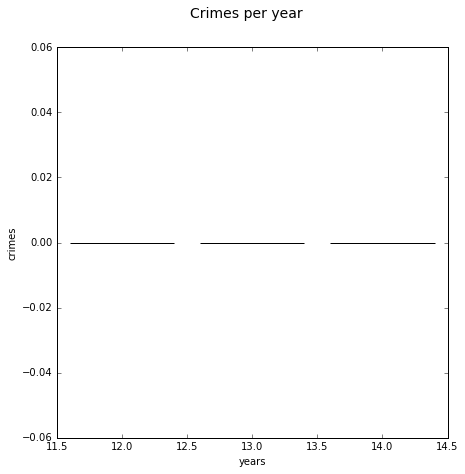

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

x_axis = [i for i in range(12, 15, 1)]
y_axis = []

for i in range(12, 15):
    try:
        y_axis.append(crime_data[i-12][0]['CNT'])
    except:
        y_axis.append(0)

fig = plt.figure(figsize=(7, 7))
fig.suptitle('Crimes per year', fontsize=14)
ax = fig.add_subplot(111)
ax.set_xlabel('years')
ax.set_ylabel('crimes')
ax.bar(x_axis, y_axis, fc='darksalmon', align='center')
plt.show()